In [49]:
# SVM人脸识别

# sklearn的fetch_lfw_people
# 此数据集是收集在互联网上的名人JPEG图片的集合，所有细节可在官方网站上获得：

# 每张图片都集中在一张脸上。每个信道的每个像素（RGB中的颜色）已经进行范围0至1中的浮点数编码。
# 这个任务叫做脸部识别（或识别）：给定一张脸的图片，查找给定训练集（图库）的人的姓名。
# 原始图像是250×250像素，但是默认切片和调整大小参数将它们减少到62×47。

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [64]:
n_samples, h, w = lfw_people.images.shape

print(n_samples, h, w)      # 样本总数，单个样本高度的特征数，单个样本宽度的特征数

50
1288 50 37


In [15]:
x = lfw_people.data

n_features = x.shape[1]     # .shape读取矩阵的长度,比如shape[0]就是读取矩阵第一维度的长度。此处读取特征的数量

print(n_features)           # 每一行代表一个样本，总有1850个特征

1850


In [12]:
y = lfw_people.target                            # 目标分类

target_names = lfw_people.target_names           # 获取人的名字

n_classes = target_names.shape[0]                # 总共有7个人的身份

print(n_classes)

7


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [75]:
# 由于特征数1850过大，使用PCA进行将维，减少特征维度，增加准确率

n_components = 150

pca = PCA(svd_solver='randomized', n_components = n_components, whiten = True).fit(x_train)             # 对训练集的向量进行建模
# whiten是一种数据预处理方式，会损失一些数据信息，但可获得更好的预测结果

eigenfaces = pca.components_.reshape((n_components, h, w))                                              # 提取特征向量（有效的人脸特征）

# 这里的特征向量是协方差矩阵的特征向量，具体含义：
# 矩阵乘法对应了一个变换，是把任意一个向量变成另一个方向或长度都大多不同的新向量。
# 在这个变换的过程中，原向量主要发生旋转、伸缩的变化。
# 如果矩阵对某一个向量或某些向量只发生伸缩变换，不对这些向量产生旋转的效果，那么这些向量就称为这个矩阵的特征向量，伸缩的比例就是特征值。

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

print(pca.components_.shape)
print(eigenfaces.shape)
# print(x_train_pca.shape[1])                                              　　　　　　　　　　　　　　 # 特征维度降低到150维 

(150, 1850)
(150, 50, 37)


In [76]:
# 使用网格搜索找到最佳参数
c = np.logspace(-2, 2, 10)
gamma = np.logspace(-2, 2, 10)

param_grid = {"C":c, "gamma":gamma}
grid = GridSearchCV(SVC(kernel = 'rbf'), param_grid)                                                     # 图像分类最常用RBF核函数
grid.fit(x_train_pca, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-02,   2.78256e-02,   7.74264e-02,   2.15443e-01,
         5.99484e-01,   1.66810e+00,   4.64159e+00,   1.29155e+01,
         3.59381e+01,   1.00000e+02]), 'gamma': array([  1.00000e-02,   2.78256e-02,   7.74264e-02,   2.15443e-01,
         5.99484e-01,   1.66810e+00,   4.64159e+00,   1.29155e+01,
         3.59381e+01,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
print(grid.best_estimator_)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [34]:
# 对训练集进行预测

y_predict = grid.predict(x_test_pca)

print(classification_report(y_test, y_predict, target_names = target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.79      0.86        19
     Colin Powell       0.79      0.79      0.79        62
  Donald Rumsfeld       0.81      0.68      0.74        31
    George W Bush       0.80      0.92      0.86       130
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.86      0.71      0.77        17
       Tony Blair       0.83      0.63      0.72        38

      avg / total       0.81      0.81      0.80       322



In [42]:
# confusion_matrix 混淆矩阵，横轴是每个预测的类，数轴是每个实际的类，对角线代表预测正确（+1）的数值相加，数值越大代表预测次数正确的

print(confusion_matrix(y_test, y_predict, labels = range(n_classes)))

[[ 15   1   0   3   0   0   0]
 [  1  49   2   9   0   0   1]
 [  0   2  21   7   0   1   0]
 [  0   5   1 120   2   1   1]
 [  0   1   1   3  19   0   1]
 [  0   0   0   2   1  12   2]
 [  0   4   1   6   3   0  24]]


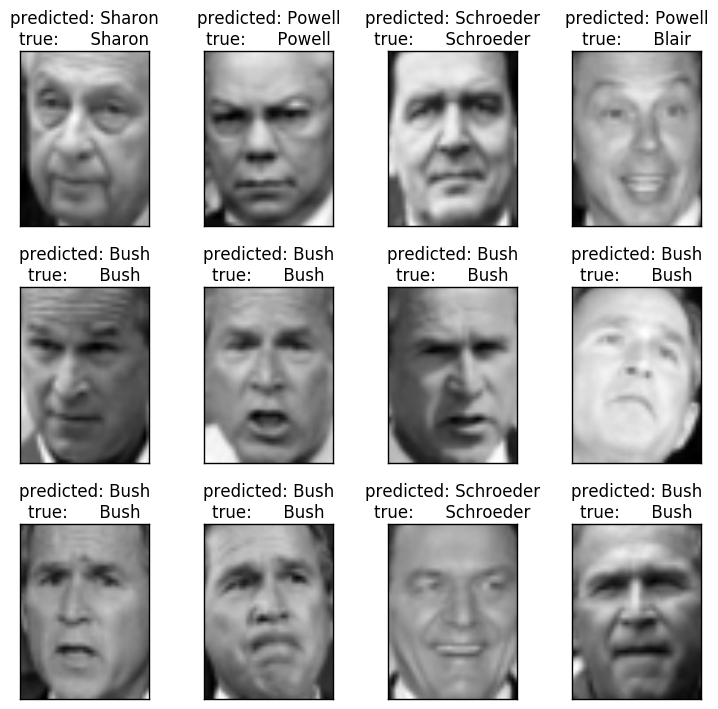

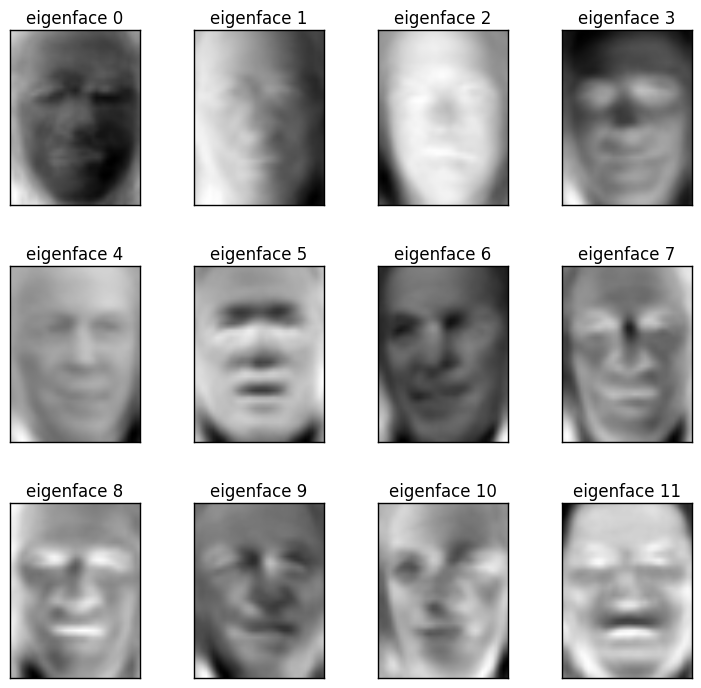

In [74]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))                                 # 创建一个新的图形，指定一个列和行的英寸
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)        # 调整子图布局
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)                                           # 在给定的网格位置返回一个子图轴。
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)                    # 在轴上显示图像，通过传入rgb的特征值。
        plt.title(titles[i], size=12)                                              # 在图上设置标题
        plt.xticks(())                                                             # 获取或设置x轴的当前勾选位置和标签.
        plt.yticks(())                                                              


# plot the result of the prediction on a portion of the test set

def title(y_predict, y_test, target_names, i):
    pred_name = target_names[y_predict[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_predict, y_test, target_names, i)
                     for i in range(y_predict.shape[0])]

plot_gallery(x_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)                                    # 展示提取特征后的人脸图像

plt.show()